In [1]:
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

from pandas_profiling import ProfileReport

region = boto3.session.Session().region_name

role = get_execution_role()

## Data Analysis

## Explain the dataset

In [2]:
BUCKET_NAME = 'c8y-ml-workbench-aws-internal-datasets'
INPUT_DATA_PATH = 'pump_sensor_data'
INPUT_DATA_FILE = 'sensor.csv'
s3 = boto3.resource('s3')
dataset_location = f's3://{BUCKET_NAME}/{INPUT_DATA_PATH}/{INPUT_DATA_FILE}'
dataset = s3.Object(BUCKET_NAME, f"{INPUT_DATA_PATH}/{INPUT_DATA_FILE}")

In [3]:
LOCAL_DATA_PATH = 'input'
dataset.download_file(f'{LOCAL_DATA_PATH}/{INPUT_DATA_FILE}')

In [4]:
import pandas as pd

input_data = f'{LOCAL_DATA_PATH}/{INPUT_DATA_FILE}'
df = pd.read_csv(input_data).drop('Unnamed: 0', axis=1)
df.machine_status = df.machine_status.astype("category")

In [5]:
df.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [6]:
profile = ProfileReport(df)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


In [7]:
profile

Number of variables,54
Number of observations,220320
Total Missing (%),2.8%
Total size in memory,89.3 MiB
Average record size in memory,425.0 B
Numeric,36
Categorical,1
Boolean,0
Date,0
Text (Unique),1
Rejected,16


In [8]:
rejected_cols = profile.get_rejected_variables() + ['sensor_15', 'sensor_32', 'sensor_33']

In [9]:
useful_df = df.drop(rejected_cols, axis=1)[df.machine_status != 'RECOVERING']

In [10]:
useful_df.columns

Index(['timestamp', 'sensor_00', 'sensor_01', 'sensor_02', 'sensor_03',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_11', 'sensor_12',
       'sensor_13', 'sensor_14', 'sensor_27', 'sensor_28', 'sensor_29',
       'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34',
       'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39',
       'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44',
       'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49',
       'sensor_50', 'sensor_51', 'machine_status'],
      dtype='object')

In [11]:
useful_df.machine_status.unique()

[NORMAL, BROKEN]
Categories (2, object): [NORMAL, BROKEN]

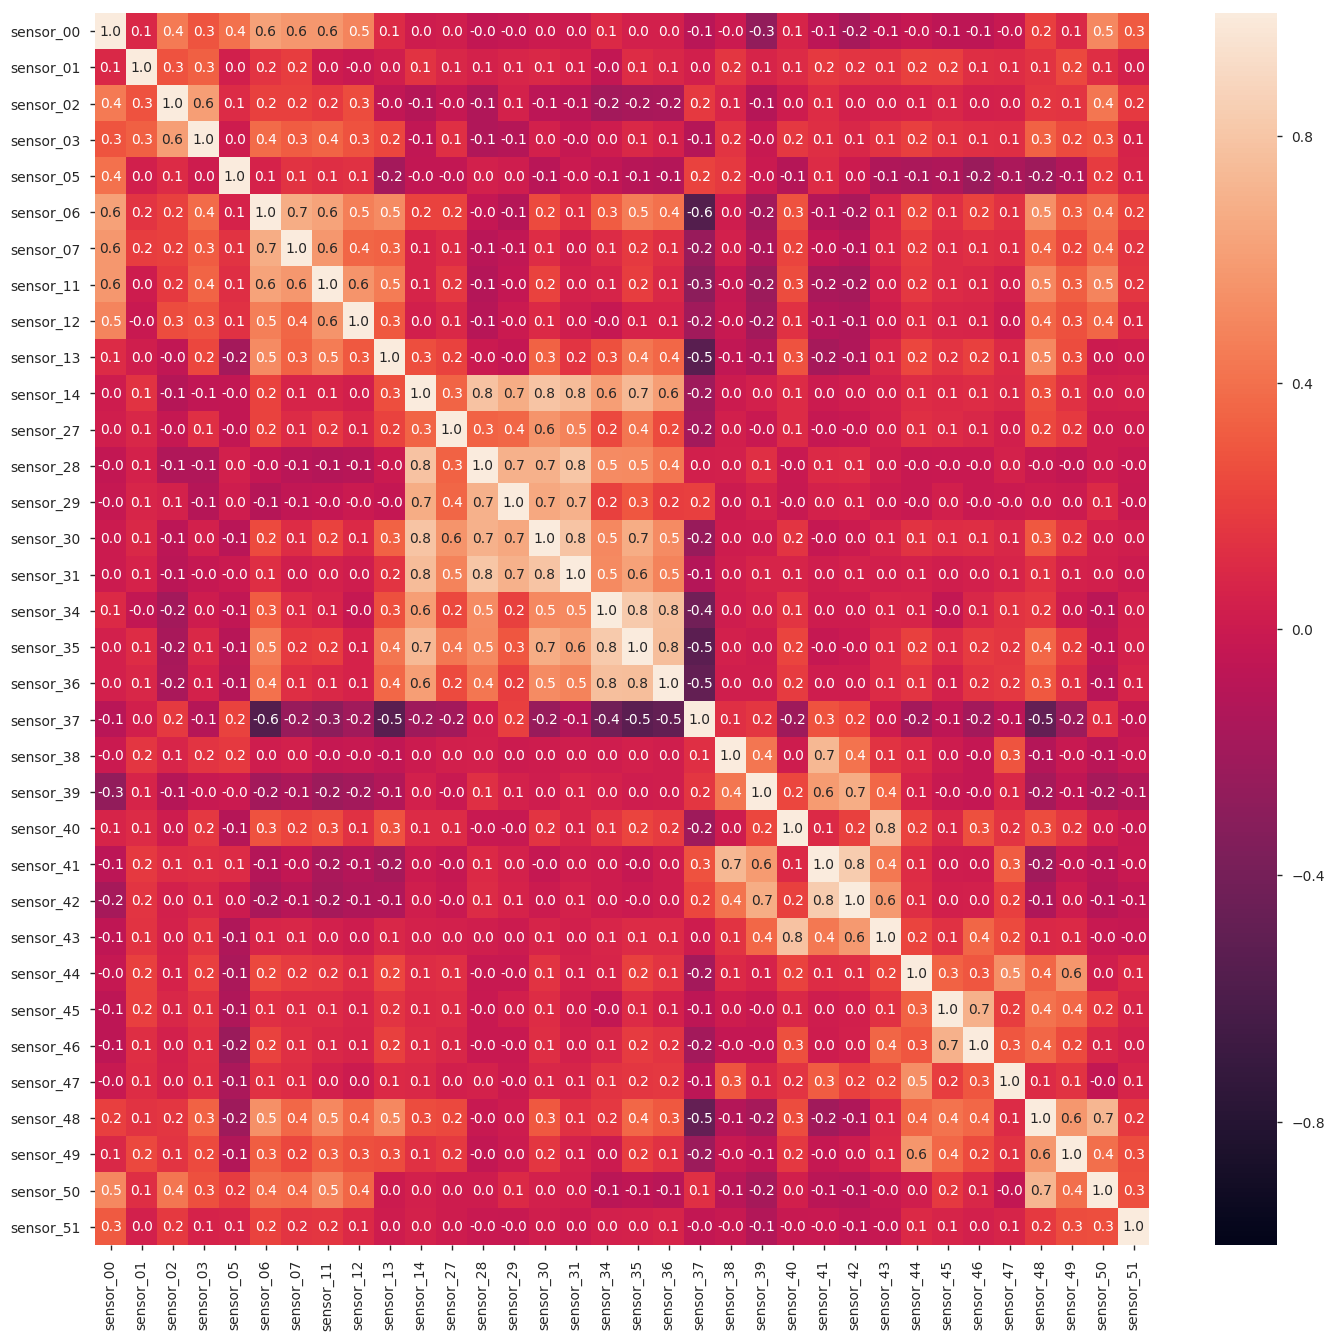

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = useful_df.corr()
plt.figure(figsize = (17,16))
sns.heatmap(corr, 
            vmin=-1.,vmax=1.,
            annot=True, fmt='.1f',
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);
#corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

## Formatting Data

In [1]:
%%writefile preprocessing.py

import argparse
import os
import warnings

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


def format_input(input_data_path, columns, target_column, class_labels):
    print('Reading input data from {}'.format(input_data_path))
    df = pd.read_csv(input_data_path)
    df = pd.DataFrame(data=df, columns=columns)[df[target_column].isin(class_labels)]
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    df[target_column].replace(class_labels, [0, 1], inplace=True)
    return df


def print_shape(df):
    negative_examples, positive_examples = np.bincount(df.machine_status)
    print('Data shape: {}, {} positive examples, {} negative examples'.format(df.shape, positive_examples, negative_examples))

def parse_args()
    parser = argparse.ArgumentParser()
    parser.add_argument('--train-test-split-ratio', type=float, default=0.3)
    parser.add_argument('--columns', nargs='+', 
                        default=['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_05', 'sensor_06',
                                 'sensor_07', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_27',
                                 'sensor_28', 'sensor_29', 'sensor_30', 'sensor_31', 'sensor_34', 'sensor_35',
                                 'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41',
                                 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45', 'sensor_46', 'sensor_47',
                                 'sensor_48', 'sensor_49', 'sensor_50', 'sensor_51', 'machine_status'])
    parser.add_argument('--target-column', type=string, default="machine_status")
    parser.add_argument('--class-labels', nargs='+', default=["BROKEN", "NORMAL"])
    parser.add_argument('--data-path', type=string, default='/opt/ml/processing/input')
    parser.add_argument('--data-file', type=string, default='sensor.csv')
    args, _ = parser.parse_known_args()
    print('Received arguments {}'.format(args))
    return args

def build_scaler(X):
    preprocess = StandardScaler()
    preprocess.fit(X)
    return preprocess

def scale(train, test, scaler):
    train, transform = (scaler.transform(train), scaler.transform(test))    
    print(f'Train data shape after preprocessing: {train.shape}')
    print(f'Test data shape after preprocessing: {test.shape}')
    return(train, transform)

def save_set(X, y, path):
    X_path = os.path.join(path, 'features.csv')
    print('Saving training features to {}'.format(X_path))
    pd.DataFrame(X).to_csv(X_path, header=False, index=False)

    y_path = os.path.join(path, 'labels.csv')
    print('Saving training labels to {}'.format(y_path))
    y.to_csv(y_path, header=False, index=False)
    
def save_params(scaler, path):
    mean_path = os.path.join(path, 'means.csv')
    means = scaler.mean_
    print('Saving means to {}'.format(mean_path))
    means.to_csv(mean_path, header=False, index=False)

    stdev_path = os.path.join(path, 'stdev.csv')
    stdevs = scaler.scale_
    print('Saving standard deviations to {}'.format(mean_path))
    stdevs.to_csv(stdev_path, header=False, index=False)
    
if __name__=='__main__':
    args = parse_args()
    columns = args.columns
    class_labels = args.class_labels
    target_column = args.target-column
    input_data_path = os.path.join(args.data_path, data_file = args)
    
    df = format_input(input_data_path, columns, target_column, class_labels)
    print_shape(df)
    
    split_ratio = args.train_test_split_ratio
    print('Splitting data into train and test sets with ratio {}'.format(split_ratio))
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(target_column, axis=1), df[target_column], test_size=split_ratio, random_state=0)

    preprocess = build_scaler(X_train)
    print('Running preprocessing and feature engineering transformations')
    train_features, test_features = scale(X_train, X_test, preprocess)
    
    save_set(X_train, y_train, '/opt/ml/processing/train')
    save_set(X_test, y_test, '/opt/ml/processing/train')
    save_params(preprocess)


Overwriting preprocessing.py


## Training a Model

In [31]:
sklearn_processor = SKLearnProcessor(framework_version='0.20.0',
                                     role=role,
                                     instance_type='ml.t3.medium',
                                     instance_count=1)

In [35]:
sklearn_processor.run(code='preprocessing.py',
                      wait=False,
                      inputs=[ProcessingInput(source=dataset_location,
                                              destination='/opt/ml/processing/input')],
                      outputs=[ProcessingOutput(output_name='train_data',
                                                source='/opt/ml/processing/train'),
                               ProcessingOutput(output_name='test_data',
                                                source='/opt/ml/processing/test')],
                      arguments=['--train-test-split-ratio', '0.2'])

preprocessing_job = sklearn_processor.jobs[-1]


Job Name:  sagemaker-scikit-learn-2020-02-05-17-50-12-025
Inputs:  [{'InputName': 'input-1', 'S3Input': {'S3Uri': 's3://c8y-ml-workbench-aws-internal-datasets/pump_sensor_data/sensor.csv', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'S3Input': {'S3Uri': 's3://sagemaker-eu-west-1-919497707409/sagemaker-scikit-learn-2020-02-05-17-50-12-025/input/code/preprocessing.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'train_data', 'S3Output': {'S3Uri': 's3://sagemaker-eu-west-1-919497707409/sagemaker-scikit-learn-2020-02-05-17-50-12-025/output/train_data', 'LocalPath': '/opt/ml/processing/train', 'S3UploadMode': 'EndOfJob'}}, {'OutputName': 'test_data', 'S3Output': {'S3Uri': 's3://sagemaker-eu-west-1

In [56]:
{output['OutputName']: output['S3Output']['S3Uri'] 
 for output in preprocessing_job.describe()['ProcessingOutputConfig']['Outputs']}

{'train_data': 's3://sagemaker-eu-west-1-919497707409/sagemaker-scikit-learn-2020-02-05-17-50-12-025/output/train_data', 'test_data': 's3://sagemaker-eu-west-1-919497707409/sagemaker-scikit-learn-2020-02-05-17-50-12-025/output/test_data'}